In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Uncompress the dataset
!unzip -uq "/content/drive/MyDrive/Paintings.zip" -d "sample_data/"

In [3]:
# Install the Cleverhans library (provides adversarial attacks)
!pip install -qq git+http://github.com/tensorflow/cleverhans.git#egg=cleverhans

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 8.9 MB/s eta 0:00:00


In [4]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import torch.optim as optim
# trochvision is part of PyTorch consisting of models and datasets for computer vision
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import vgg16

In [5]:
class MyDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, 'images')
        self.labels_file = pd.read_csv(os.path.join(root_dir, 'labels.csv'), header=None)
        self.transform = transform

    def __len__(self):
        return len(self.labels_file)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, f'img_{idx + 1:04}.jpg')
        image = Image.open(img_name)
        image = self.transform(image)
        label = self.labels_file.iloc[idx, 0]

        return image, label

In [6]:
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

dataset = MyDataset(root_dir='sample_data/Paintings', transform=transform)

In [7]:
print(len(dataset))

3988


In [8]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test subsets
train_indices_1, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=123)

# Split the dataset into train and validation subsets
train_indices, val_indices = train_test_split(train_indices_1, test_size=0.2, random_state=123)

In [9]:
# Create training, testing, and validation subsets
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)
val_dataset = Subset(dataset, val_indices)

In [10]:
# Create training, testing, and validation dataloaders for iterating over the datasets
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=64)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=64)

In [11]:
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

2552
798
638


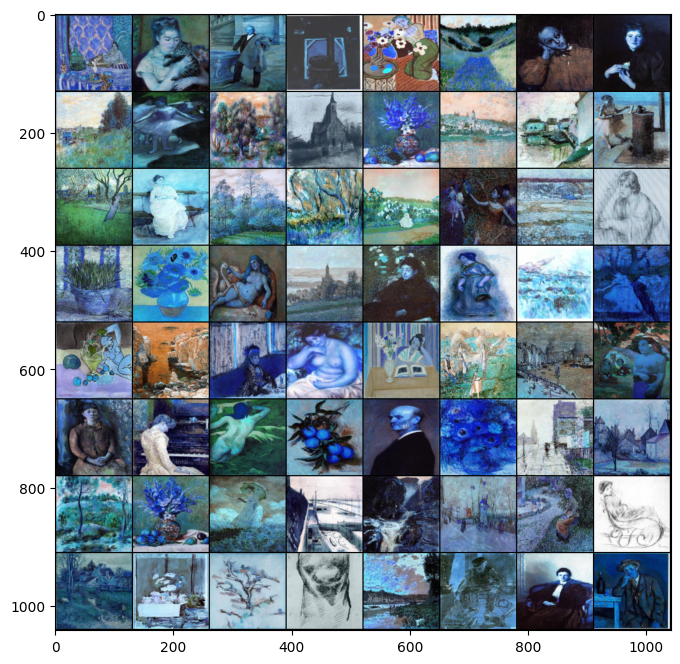

In [12]:
# show several images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get a batch of random training images and labels
images, labels = next(iter(train_dataloader))

# show images
plt.figure(figsize=(8,8))
imshow(torchvision.utils.make_grid(images))

In [13]:
# Import pretrained VGG16
VGG16 = vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 96.9MB/s]


In [14]:
# Change the output in the last layer to 10 classes
VGG16.classifier._modules['6'] = nn.Linear(4096, 10)

In [15]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
# Move the model to the GPU
VGG16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
# function to train the model for one epoch on the given set
def train(model, train_loader, criterion, optimizer, epoch):
    running_loss, total, sum_correct = 0.0, 0, 0

    # indicate this is a training step
    model.train()

    for i, data in enumerate(train_loader):
        images, labels = data
        labels = labels.type(torch.LongTensor)
        images, labels = images.to(device), labels.to(device)

        # forward + loss + backward + update
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # calculate loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        sum_correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # return the accuracy and loss
    return sum_correct/total, running_loss


# function to evaluate the model on the given set
def validate(model, val_loader, criterion):
    running_loss, total, sum_correct = 0.0, 0, 0

    # indicate this is an evaluation step
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            labels = labels.type(torch.LongTensor)
            images, labels = images.to(device), labels.to(device)

            # Compute the output: forward pass only
            outputs = model(images)
            loss = criterion(outputs, labels)

            # calculate loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            sum_correct += (predicted == labels).sum().item()

    # return the accuracy and loss
    return sum_correct/total, running_loss

In [18]:
# training loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(VGG16.parameters(), lr=0.0001)

In [20]:
# total number of training epochs
epoch_num = 60

# initialize variables to save the training and validation loss and accuracy
training_loss_plot = []
training_accuracy_plot = []
val_loss_plot = []
val_accuracy_plot = []

import datetime
now = datetime.datetime.now
t = now()

# loop over the number of epochs
for epoch in range(epoch_num):

    # train for one epoch: return accuracy and loss
    tr_accuracy, tr_loss = train(VGG16, train_dataloader, criterion, optimizer, epoch)

    # evaluate after each epoch: return accuracy and loss
    val_accuracy, val_loss = validate(VGG16, val_dataloader, criterion)

    # append the accuracies and losses after each epoch
    training_accuracy_plot.append(tr_accuracy)
    training_loss_plot.append(tr_loss)
    val_accuracy_plot.append(val_accuracy)
    val_loss_plot.append(val_loss)

    # Display after each epoch
    print(f'Epoch: {epoch + 1}/{epoch_num}\t Training loss: {tr_loss:.3f}\t',
              f'Training accuracy: {100*tr_accuracy:2.3f}\t Validation accuracy: {100*val_accuracy:2.3f}')

print('Training time: %s' % (now() - t))

Epoch: 1/60	 Training loss: 62.160	 Training accuracy: 46.434	 Validation accuracy: 53.448
Epoch: 2/60	 Training loss: 41.454	 Training accuracy: 64.655	 Validation accuracy: 59.718
Epoch: 3/60	 Training loss: 26.980	 Training accuracy: 77.586	 Validation accuracy: 59.875
Epoch: 4/60	 Training loss: 20.520	 Training accuracy: 82.406	 Validation accuracy: 62.539
Epoch: 5/60	 Training loss: 11.356	 Training accuracy: 90.400	 Validation accuracy: 60.658
Epoch: 6/60	 Training loss: 11.119	 Training accuracy: 90.439	 Validation accuracy: 63.009
Epoch: 7/60	 Training loss: 5.010	 Training accuracy: 95.611	 Validation accuracy: 66.928
Epoch: 8/60	 Training loss: 2.099	 Training accuracy: 97.923	 Validation accuracy: 62.226
Epoch: 9/60	 Training loss: 6.125	 Training accuracy: 95.298	 Validation accuracy: 60.031
Epoch: 10/60	 Training loss: 4.538	 Training accuracy: 96.473	 Validation accuracy: 66.458
Epoch: 11/60	 Training loss: 1.542	 Training accuracy: 98.903	 Validation accuracy: 62.069
Ep

# b.Plot the training and validation loss and accuracy curves.

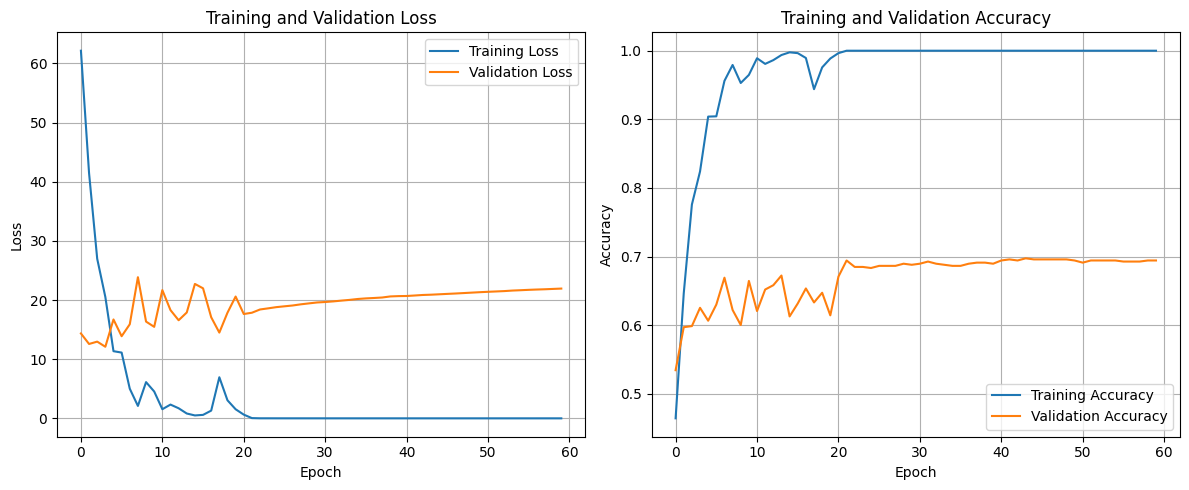

In [21]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(training_loss_plot, label='Training Loss')
plt.plot(val_loss_plot, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy_plot, label='Training Accuracy')
plt.plot(val_accuracy_plot, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

# a.It is expected to report test accuracy above 70%

In [22]:
# calculate the accuracy and loss on the test dataset
test_accuracy, test_loss = validate(VGG16, test_dataloader, criterion)
print(f'Test dataset accuracy: {100*test_accuracy:2.3f}')
print(f"Training Accuracy: {100 * training_accuracy_plot[-1]:.3f}%")
print(f"Validation Accuracy: {100 * val_accuracy_plot[-1]:.3f}%")

Test dataset accuracy: 71.930
Training Accuracy: 100.000%
Validation Accuracy: 69.436%


# Task 2

In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent
from torchvision import models

In [25]:
# Function to generate FGSM adversarial examples
def generate_fgsm_adversarial_examples(model, images, labels, epsilon=10/255.):
    images = images.clone().detach().requires_grad_(True)

    # forward + loss + backward + update
    outputs = model(images)
    loss = criterion(outputs, labels)
    model.zero_grad()
    loss.backward()

    # Generate adversarial examples using FGSM
    adv_image = images + epsilon * images.grad.sign()
    # Ensure pixel values are in the range [0,1]
    adv_image = torch.clamp(adv_image, 0, 1)

    return adv_image.detach()

In [26]:
# Generate FGSM adversarial examples on the test dataset
adv_image_list = []
labels_list = []

for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Generate FGSM adversarial examples using the provided function
        adv_image = generate_fgsm_adversarial_examples(VGG16, images, labels, epsilon=10/255.)
        adv_pred= generate_fgsm_adversarial_examples(VGG16, images, labels, epsilon=10/255.)

        # Append images and labels
        adv_image_list.append(adv_image.detach().cpu())
        labels_list.append(labels.cpu())

# Convert lists to tensors
adv_image_tensor = torch.cat(adv_image_list, dim=0)
adv_label_tensor = torch.cat(labels_list, dim=0)


In [27]:
# Create a dataset from tensors
fgsm_adv_dataset = TensorDataset(adv_image_tensor, adv_label_tensor)

# Create a DataLoader
fgsm_adv_dataloader = DataLoader(fgsm_adv_dataset, batch_size=64, shuffle=False)

# It is expected that the classification accuracy on the generated adversarial examples is below 20%

In [28]:
# calculate the accuracy of the FGSM attack on test dataset
test_accuracy, test_loss = validate(VGG16, fgsm_adv_dataloader, criterion)
print(f'FGSM adversarial examples accuracy: {100*test_accuracy:2.3f}')

FGSM adversarial examples accuracy: 2.506


# **Plot at least 9 adversarial images with their true and predicted labels**

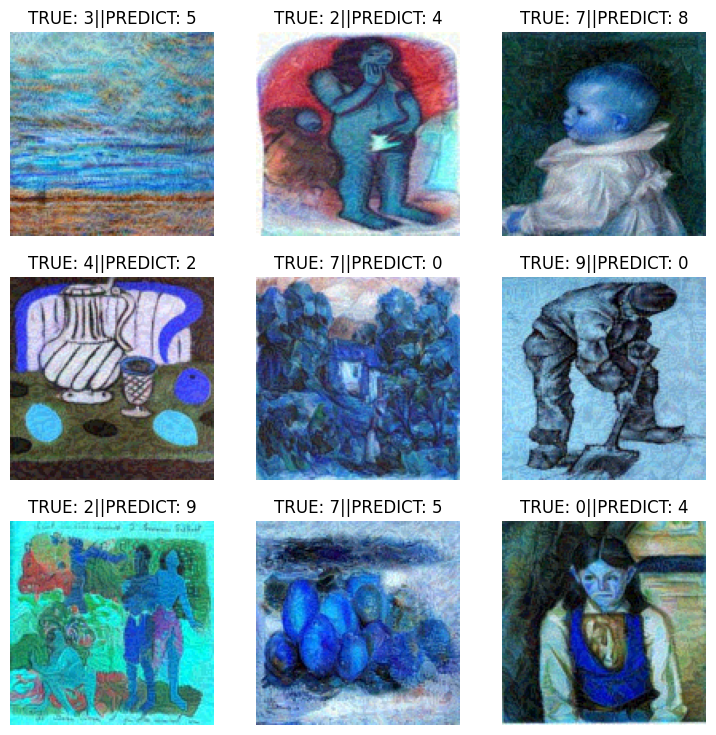

In [29]:
# Display the first 9 adversarial images with true and predicted labels
outputs = VGG16(adv_image)
predicted = torch.argmax(outputs, dim=1)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))
for i, ax in enumerate(axes.flat[:10]):
    img = adv_image[i].detach().cpu().numpy().transpose((1, 2, 0))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"TRUE: {labels[i].item()}||PREDICT: {predicted[i].item()}")

plt.show()

# Task 3

In [30]:
def generate_pgd_adversarial_examples(model, images, labels, epsilon=10/255., alpha=0.01, iters=10, random_start=True):

    # Clone and detach images
    adv_images = images.clone().detach().to(images.device)

    if random_start:
        # Start with random noise within [-epsilon, epsilon]
        adv_images = adv_images + (2 * epsilon * torch.rand_like(adv_images) - epsilon)
        adv_images = torch.clamp(adv_images, 0, 1)  # Ensure pixel values are valid

    for _ in range(iters):
        adv_images.requires_grad = True  # Enable gradient tracking
        model.eval()  # Ensure model is in evaluation mode
        outputs = model(adv_images)

        loss = criterion(outputs, labels)  # Compute loss

        model.zero_grad()
        if adv_images.grad is not None:
            adv_images.grad.zero_()  # Ensure no residual gradients

        loss.backward()

        with torch.no_grad():  # Disable gradient tracking for update step
            # Compute perturbation using sign of gradient
            perturbation = alpha * adv_images.grad.sign()
            adv_images = adv_images + perturbation

            # Project back to epsilon-ball around original images
            perturbation = torch.clamp(adv_images - images, -epsilon, epsilon)
            adv_images = torch.clamp(images + perturbation, 0, 1)

        adv_images = adv_images.detach()  # Detach for next iteration

    return adv_images

In [31]:
# use a subset fo 200 images for the PGD attack
sub_dataset = Subset(test_dataset, list(range(200)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

In [32]:
# Generate PGD adversarial examples on the subset of 200 images
adv_images_list = []
labels_list = []

for images, labels in subsest_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Generate PGD adversarial examples using the provided function
        adv_images = generate_pgd_adversarial_examples(VGG16, images, labels, epsilon=10/255., alpha=0.01, iters=10, random_start=True)

        # Append images and labels
        adv_images_list.append(adv_images.detach().cpu())
        labels_list.append(labels.cpu())

# Convert lists to tensors
adv_images_tensor = torch.cat(adv_images_list, dim=0)
adv_labels_tensor = torch.cat(labels_list, dim=0)

In [33]:
# Create a dataset from tensors
pgd_adv_dataset = TensorDataset(adv_images_tensor, adv_labels_tensor)

# Create a DataLoader
pgd_adv_dataloader = DataLoader(pgd_adv_dataset, batch_size=64, shuffle=False)

# It is expected that the classification accuracy is below 20%

In [34]:
# calculate the accuracy of the PGD attack on test dataset
test_accuracy, test_loss = validate(VGG16, pgd_adv_dataloader, criterion)
print(f'PGD adversarial examples accuracy: {100*test_accuracy:2.3f}')

PGD adversarial examples accuracy: 0.000


# **Plot at least 9 adversarial images with their true and predicted labels**

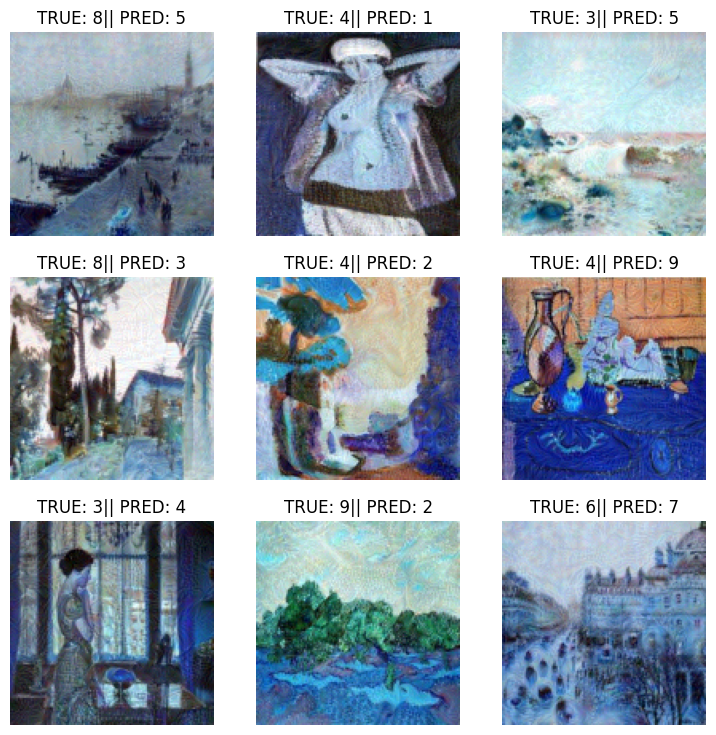

In [35]:
num_samples = 9
indices = torch.randperm(len(adv_images_tensor))[:num_samples]

adv_images = adv_images_tensor[indices]
adv_labels = adv_labels_tensor[indices]
with torch.no_grad():
    outputs = VGG16(adv_images.to(device))
    _, predicted_labels = torch.max(outputs, 1)

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()

for i in range(9):
    ax = axes[i]
    ax.imshow(adv_images[i].permute(1, 2, 0).numpy())  # Convert tensor to image format
    ax.set_title(f'TRUE: {adv_labels[i].item()}|| PRED: {predicted_labels[i].item()}')
    ax.axis('off')


plt.show()

# Task 4

In [42]:
# Function to perform adversarial training with FGSM examples
def adversarial_training(model, train_loader, optimizer, epochs=3, epsilon=0.3):

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Generate FGSM adversarial examples
            adv_images = generate_fgsm_adversarial_examples(model, images, labels, epsilon)

            # Mix clean and adversarial examples
            mixed_images = torch.cat([images, adv_images], dim=0)
            mixed_labels = torch.cat([labels, labels], dim=0)

            # forward + loss + backward + update
            outputs = model(mixed_images)
            loss = criterion(outputs, mixed_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")


In [43]:
t = now()
adversarial_training(VGG16, train_dataloader, optimizer, epochs=15, epsilon=10/255.)
print('Time for adversarial training: %s' % (now() - t))

Epoch [1/15], Loss: 1.1203
Epoch [2/15], Loss: 1.0614
Epoch [3/15], Loss: 0.9264
Epoch [4/15], Loss: 0.8334
Epoch [5/15], Loss: 0.7929
Epoch [6/15], Loss: 0.6967
Epoch [7/15], Loss: 0.7157
Epoch [8/15], Loss: 0.6468
Epoch [9/15], Loss: 0.5739
Epoch [10/15], Loss: 0.5466
Epoch [11/15], Loss: 0.5134
Epoch [12/15], Loss: 0.5588
Epoch [13/15], Loss: 0.5166
Epoch [14/15], Loss: 0.4405
Epoch [15/15], Loss: 0.3794
Time for adversarial training: 0:09:19.683030


In [44]:
# calculate the accuracy on the clean train dataset
test_accuracy, test_loss = validate(VGG16, train_dataloader, criterion)
print(f'Clean train dataset accuracy: {100*test_accuracy:2.3f}')

Clean train dataset accuracy: 99.843


In [45]:
# calculate the accuracy on the clean test dataset
test_accuracy, test_loss = validate(VGG16, test_dataloader, criterion)
print(f'Clean test dataset accuracy: {100*test_accuracy:2.3f}')

Clean test dataset accuracy: 64.787


# The robust accuracy on the adversarial samples created with FGSM should be greater than 40%.

In [46]:
# calculate the accuracy on the FGSM adversarial exmaples
test_accuracy, test_loss = validate(VGG16, fgsm_adv_dataloader, criterion)
print(f'FGSM adversarial examples accuracy accuracy: {100*test_accuracy:2.3f}')

FGSM adversarial examples accuracy accuracy: 50.877


In [47]:
# calculate the accuracy on the PGD adversarial exmaples
test_accuracy, test_loss = validate(VGG16, pgd_adv_dataloader, criterion)
print(f'PGD adversarial examples accuracy accuracy: {100*test_accuracy:2.3f}')

PGD adversarial examples accuracy accuracy: 22.000


## End of **PART** **TWO**